In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import pandas as pd
import numpy as np
from ladybug.epw import EPW
import matplotlib.pyplot as plt
from matplotlib import dates, ticker
pd.plotting.register_matplotlib_converters()

import oshe as tc

Failed to load paths from C:\Users\tgerrish\Miniconda3\lib\site-packages\honeybee\config.json.
Path to radiance is set to: c:/radiance


In [2]:
idd_file = r"C:\openstudio-2.9.0\EnergyPlus\Energy+.idd"
epw_file = r"./example/weatherfile.epw"

In [3]:
def generate_results(epw_file, idd_file, ground_material, shaded=False):
    
    # Load epw
    epw = EPW(epw_file)

    # Get climate variables
    dbt = np.roll(np.array(epw.dry_bulb_temperature.values), -1)
    rh = np.roll(np.array(epw.relative_humidity.values), -1)
    ws = np.roll(np.array(epw.wind_speed.values), -1)
    hir = np.roll(np.array(epw.horizontal_infrared_radiation_intensity.values), -1)
    sun_altitude = tc.helpers.sun_altitude(epw_file)
    
    # Define ground zone from material (using predefined dictionary of properties)
    gnd_mat = tc.material.material_dict[ground_material]
    ground_zone = tc.geometry.Ground(gnd_mat, xy=5, depth=1.5, subsurface_size=5)
    
    # Create shade objects if shaded
    if shaded:
        shades = [
            tc.geometry.Shade(vertices=[[5, 5, 3], [5, 5, 0], [5, -5, 0], [5, -5, 3]]),
            tc.geometry.Shade(vertices=[[5, -5, 3], [5, -5, 0], [-5, -5, 0], [-5, -5, 3]]),
            tc.geometry.Shade(vertices=[[-5, -5, 3], [-5, -5, 0], [-5, 5, 0], [-5, 5, 3]]),
            tc.geometry.Shade(vertices=[[-5, 5, 3], [-5, 5, 0], [5, 5, 0], [5, 5, 3]]),
            tc.geometry.Shade(vertices=[[-5, -5, 3], [-5, 5, 3], [5, 5, 3], [5, -5, 3]]),
        ]
    else:
        shades = None
    
    of_srf_temp = tc.energyplus.run_energyplus(epw_file, idd_file, ground=ground_zone, shades=shades, run=True)  # Calculate ground surface temperature
    of_dir_rad, of_dif_rad = tc.radiance.run_radiance(epw_file, ground=ground_zone, shades=shades, run=True)  # Calculate incident solar direct and diffuse radiation
    
    # Calculate MRT & UTCI
    of_mrt = tc.mrt.mean_radiant_temperature(surrounding_surfaces_temperature=of_srf_temp[0], horizontal_infrared_radiation_intensity=hir, diffuse_horizontal_solar=of_dif_rad.T[0], direct_normal_solar=of_dir_rad.T[0], sun_altitude=sun_altitude, ground_reflectivity=gnd_mat.reflectivity, sky_exposure=0 if shaded else 1)[0]
    of_utci = tc.utci.universal_thermal_climate_index(dbt, of_mrt, ws, rh)
    
    return {
        ground_material + "_{0:}".format("SHADED" if shaded else "UNSHADED"): {
            "srf_temp": of_srf_temp[0],
            "mrt": of_mrt,
            "utci": of_utci
        }
    }

In [4]:
# Simulate cases
res = []
for mat in ["CONCRETE", "GRASS", "ASPHALT", "SAND", "SANDSTONE", "SHRUBS", "LIMESTONE", "HARDWOOD", "SOFTWOOD"]:
    for shaded in [True, False]:
        print("\nRunning for {} {}".format("SHADED" if shaded else "UNSHADED", mat))
        res.append(generate_results(epw_file, idd_file, mat, shaded=shaded))



Running for SHADED CONCRETE
Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.07 seconds]
Universal thermal climate index calculated [0.09 seconds]

Running for UNSHADED CONCRETE
Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temper

Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.07 seconds]
Universal thermal climate index calculated [0.09 seconds]

Running for SHADED SOFTWOOD
Ground surface temperature simulation completed
EnergyPlus results loaded
Writing recipe contents to: C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual
Calculating solar values...
# Number of sun up hours: 4423
Writing sun matrix to C:\Users\tgerrish\AppData\Local\Temp\openfield\gridbased_annual\sky\sunmtx.smx
Direct and diffuse solar radiation simulation completed
Radiance results loaded
Mean radiant temperature calculated [0.08 seconds]
Universal thermal climate index calculated [0.09 seconds]

Running for UN

In [5]:
# Join results into DataFrame
result = {}
for d in res:
    result.update(d)

ll = []
for k, v in result.items():
    ll.append(pd.DataFrame.from_dict(v).set_index(pd.date_range("2018-01-01", periods=8760, freq="60T", closed="left")))

df = pd.concat(ll, axis=1, keys=list(result.keys()))

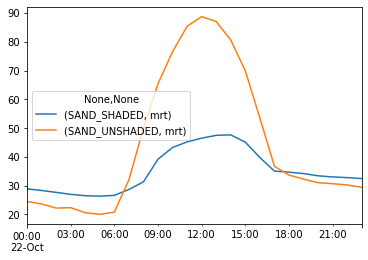

In [22]:
df.filter(regex="SAND_").filter(regex="mrt")["2018-10-22"].plot()

In [6]:
# Write results to file
df

CONCRETE_SHADED                       CONCRETE_UNSHADED  \
                           srf_temp        mrt       utci          srf_temp   
2018-01-01 00:00:00       19.122644  19.122644  14.413861         19.367595   
2018-01-01 01:00:00       18.846250  18.846250  15.602900         18.529840   
2018-01-01 02:00:00       18.594615  18.594615  13.365037         17.803777   
2018-01-01 03:00:00       18.361235  18.361235  10.351991         17.132135   
2018-01-01 04:00:00       18.082217  18.082217   9.951932         16.434498   
...                             ...        ...        ...               ...   
2018-12-31 19:00:00       21.789023  21.789023  19.272474         26.449446   
2018-12-31 20:00:00       21.662897  21.662897  22.234705         25.361094   
2018-12-31 21:00:00       21.618674  21.618674  23.713427         24.698749   
2018-12-31 22:00:00       21.486017  21.486017  23.970185         23.971614   
2018-12-31 23:00:00       21.361110  21.361110  23.531763         23.072647   

                                          GRASS_SHADED                        \
                           mrt       utci     srf_temp        mrt       utci   
2018-01-01 00:00:00  14.967323  13.098736    20.095558  20.095558  14.720948   
2018-01-01 01:00:00  14.037603  14.022296    19.338633  19.338633  15.764020   
2018-01-01 02:00:00  13.571736  11.748971    18.712294  18.712294  13.402820   
2018-01-01 03:00:00  12.614132   8.513082    18.140928  18.140928  10.281496   
2018-01-01 04:00:00  11.846164   7.952357    17.522242  17.522242   9.772251   
...                        ...        ...          ...        ...        ...   
2018-12-31 19:00:00  21.748891  19.261459    26.711669  26.711669  20.619345   
2018-12-31 20:00:00  21.583074  22.212379    25.795993  25.795993  23.385895   
2018-12-31 21:00:00  22.553427  23.985889    25.309311  25.309311  24.784967   
2018-12-31 22:00:00  20.319681  23.619425    24.747839  24.747839  24.944004   
2018-12-31 23:00:00  20.155359  23.173635    24.119236  24.119236  24.346334   

                    GRASS_UNSHADED  ... HARDWOOD_SHADED HARDWOOD_UNSHADED  \
                          srf_temp  ...            utci          srf_temp   
2018-01-01 00:00:00      20.589268  ...       14.371839         13.765471   
2018-01-01 01:00:00      19.778804  ...       15.442027         12.671383   
2018-01-01 02:00:00      19.102241  ...       13.136641         11.905691   
2018-01-01 03:00:00      18.486194  ...       10.066183         11.219303   
2018-01-01 04:00:00      17.829580  ...        9.598536         10.433882   
...                            ...  ...             ...               ...   
2018-12-31 19:00:00      26.722725  ...       19.516747         21.663465   
2018-12-31 20:00:00      25.351484  ...       22.445117         20.285985   
2018-12-31 21:00:00      24.055715  ...       23.924052         19.948633   
2018-12-31 22:00:00      23.185246  ...       24.132172         19.226856   
2018-12-31 23:00:00      22.400280  ...       23.654571         18.060268   

                                          SOFTWOOD_SHADED             \
                           mrt       utci        srf_temp        mrt   
2018-01-01 00:00:00  12.166261  12.209949       18.900240  18.900240   
2018-01-01 01:00:00  11.108374  13.054510       18.203027  18.203027   
2018-01-01 02:00:00  10.622693  10.798350       17.709684  17.709684   
2018-01-01 03:00:00   9.657716   7.568595       17.274564  17.274564   
2018-01-01 04:00:00   8.845856   6.993004       16.763486  16.763486   
...                        ...        ...             ...        ...   
2018-12-31 19:00:00  19.355901  18.603816       22.706492  22.706492   
2018-12-31 20:00:00  19.045519  21.501002       22.445967  22.445967   
2018-12-31 21:00:00  20.178369  23.292300       22.385221  22.385221   
2018-12-31 22:00:00  17.947302  22.902219       22.039850  22.039850   
2018-12-31 23:00:00  17.649170  22.425716       21.777550  21.777550   

            

In [23]:
outdir = r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results"

nn = 0
for i in np.unique(df.columns.get_level_values(0)):
    for k in ["mrt", "srf"]:
        outpath = os.path.join(outdir, "_openfield_sc_{}.{}".format(i.lower(), k.replace("srf", "srftemp")))
        print(outpath)
#         outpath = r"C:\Users\tgerrish\Desktop\deleteme\test.csv"

        df.filter(regex=i).filter(regex=k).round(5).to_csv(outpath, header=False, index=False)
        nn += 1

C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_asphalt_shaded.mrt
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_asphalt_shaded.srftemp
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_asphalt_unshaded.mrt
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_asphalt_unshaded.srftemp
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_concrete_shaded.mrt
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_concrete_shaded.srftemp
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_concrete_unshaded.mrt
C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Resu

In [33]:
a = [
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P2.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P3.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P3.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\CapitalGardens.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\CapitalGardens.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\ChamberOfCommerce_1.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\ChamberOfCommerce_1.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\ChamberOfCommerce_2.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\ChamberOfCommerce_2.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportPark.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportPark.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P1.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P1.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\AirportRd_P2.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\Municipality.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\StreetFacelifts_P1.mrt", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\StreetFacelifts_P1.utci", 
    r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\Municipality.mrt", 
]

idx = 3
for idx, i in a:
    try:
        pd.read_csv(a[idx]).drop("hoy", axis=1).to_csv(a[idx], header=False, index=False)
        print("Removed header info on")
    except:
        print("Didn't do nufink. probably alright")

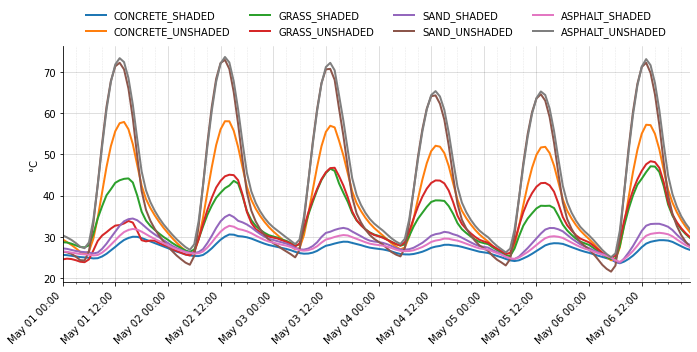

In [127]:
# Plot case results

vals = df["2018-05-01": "2018-05-06"].filter(regex="temp")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in vals:
    ax.plot(vals[i], label=i[0], lw=2)

# Format canvas
ax.set_xlim(vals.index.min(), vals.index.max())
ax.xaxis.set_major_locator(dates.HourLocator(byhour=np.arange(0, 25, 12)))
ax.xaxis.set_major_formatter(dates.DateFormatter('%b %d %H:%M'))
ax.xaxis.set_minor_locator(dates.HourLocator(byhour=np.arange(0, 25, 3)))
[ax.spines[spine].set_visible(False) for spine in ['top', 'right']]
ax.grid(b=True, which='minor', axis='both', c="k", ls='--', lw=0.5, alpha=0.1)
ax.grid(b=True, which='major', axis='both', c="k", ls='-', lw=0.5, alpha=0.25)
plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='medium')
ax.set_ylabel("°C", color="k")

# Legend
lgd = ax.legend(frameon=False, bbox_to_anchor=(0.5, 1), loc="lower center", ncol=4)
[plt.setp(text, color="k") for text in lgd.get_texts()]

plt.tight_layout()

In [65]:
idx = pd.date_range("2018-01-01 00:00:00", freq="60T", periods=8760)

# Load epw
epw = EPW(epw_file)

# Get climate variables
dbt = np.roll(np.array(epw.dry_bulb_temperature.values), -1)
rh = np.roll(np.array(epw.relative_humidity.values), -1)
ws = np.roll(np.array(epw.wind_speed.values), -1)

pt_mrt = pd.read_csv(r"C:\Users\tgerrish\Documents\GitHub\oshe\projects\EXAMPLE\result.mrt").values
of_mrt = pd.read_csv(r"C:\Users\tgerrish\BuroHappold\045131 Ghadan 21 Future Parks - Compare Projects Results\Results\_openfield_sc_concrete_unshaded.mrt", header=None).squeeze().values

# Calculate UTCI matrix
of_utci = tc.utci.universal_thermal_climate_index(dbt, of_mrt, ws, rh)
pt_utci = tc.utci.universal_thermal_climate_index(dbt, pt_mrt.T, ws, rh).T

utci = tc.plot.UTCI(of_utci, pt_utci.T, np.repeat(np.array([np.array([0, 0, 0])]), pt_utci.shape[1], axis=0))

Universal thermal climate index calculated [0.09 seconds]
Universal thermal climate index calculated [0.32 seconds]


In [72]:
utci.reduction_summary(threshold=4, percentile=0.95)

,Annual,May,October
07:00 - 10:00,0.441781,0.508065,0.500000
16:00 - 19:00,0.476712,0.580645,0.354839
